<a href="https://colab.research.google.com/github/protaxY/AIDL_labs/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

In [3]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]
num_labels = len(VOC_CLASSES)

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]
VOC_COLORS = np.array(VOC_COLORMAP)


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [4]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, Perspective, RandomSizedCrop, OneOf, PadIfNeeded, Resize

In [5]:
train_augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 Flip(p=0.5),
                 Perspective(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])
val_augs = Compose([
                 Resize(256,256)
])

In [6]:
train_dataset = PascalVOCSearchDataset('train', image_set = 'train', download = True, transform = train_augs)
validation_dataset = PascalVOCSearchDataset('val', image_set = 'val', download = True, transform = val_augs)

Using downloaded and verified file: train/VOCtrainval_11-May-2012.tar
Extracting train/VOCtrainval_11-May-2012.tar to train
Using downloaded and verified file: val/VOCtrainval_11-May-2012.tar
Extracting val/VOCtrainval_11-May-2012.tar to val


In [7]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

In [8]:
validation_dataset[0][1].shape

torch.Size([21, 256, 256])

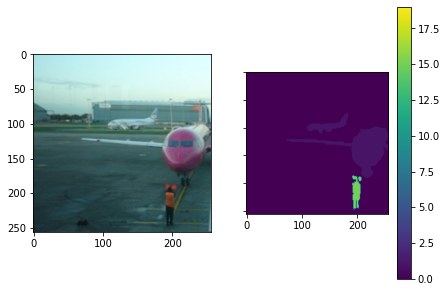

In [9]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [10]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [11]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
optim = torch.optim.AdamW(model.parameters(), lr = 1e-5, weight_decay = 1e-5)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)
val_dataloader = DataLoader(validation_dataset, batch_size = 8, num_workers = 2)

loaders = {'train': train_dataloader, 'val': val_dataloader}

In [14]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [15]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [16]:
def IoU(predictions, labels):
  masks = torch.permute(torch.nn.functional.one_hot(predictions.argmax(1), labels.shape[1]), (0, 3, 1, 2))

  intersection = (masks & labels.int()).sum((2, 3))+1
  union = (masks | labels.int()).sum((2, 3))+1
  return intersection/union

def MIoU(predictions, labels):
  iou = IoU(predictions, labels)
  return torch.mean(iou, 1)

In [17]:
def IoU(predict, labels):
    predict = predict.softmax(1)
    predict = predict.argmax(1)
    predict = torch.nn.functional.one_hot(predict, len(VOC_CLASSES))
    predict = torch.permute(predict, (0, 3, 1, 2))
    with torch.no_grad():
        intersection = (predict & labels.int()).sum([2, 3])
        union = (predict | labels.int()).sum([2, 3])
    return intersection / (union + 1e-6)

def MioU(predict, labels):
    batch_iou = IoU(predict, labels)
    batch_mou = []
    for iou in batch_iou:
        batch_mou += [iou[iou != 0].mean()]
    return torch.stack(batch_mou)

In [44]:
train_loss_history = []
val_loss_history = []

val_miou_history = []

next_desc = "first epoch"
for epoch in range(10):
  train_loss = 0
  val_loss = 0
  val_iou_sums = torch.zeros(num_labels).cuda()
  val_iou_class_counts = torch.zeros(num_labels).cuda()
  val_mean_miou = 0
  for mode, dataloader in loaders.items():
    for img, lbl in tqdm(dataloader, desc = next_desc):
      img = img.cuda()
      lbl = lbl.cuda()
      if mode == 'train':
        model.train()
        predictions = model(img)['out']
        loss = crit(predictions, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()

        train_loss += loss.detach().cpu().item()/len(dataloader)

      else:
        model.eval()
        with torch.no_grad():
          predictions = model(img)['out']
          loss = crit(predictions, lbl)

          val_loss += loss.detach().cpu().item()/len(dataloader)

          iou = IoU(predictions, lbl)
          val_iou_sums += iou.sum(0)
          for i in iou.nonzero()[:, 1].tolist():
            val_iou_class_counts[i] += 1
          val_mean_miou += ((iou.sum(1)/(iou.count_nonzero(1) + 1e-6)).mean().item())/len(dataloader)
    
    if mode == 'train':
      train_loss_history += [train_loss]
      next_desc = f"Epoch: [{epoch+1}], previous train_loss: [{train_loss:.3f}]"
    else:
      val_loss_history += [val_loss]
      val_miou_history += [(val_iou_sums/val_iou_class_counts).tolist()]
      next_desc = f"previous val_loss: [{val_loss:.3f}], previous miou: [{val_mean_miou:.3f}]"

Epoch: [1], previous train_loss: [0.484]: 100%|██████████| 182/182 [02:52<00:00,  1.06it/s]


In [42]:
plot_val_miou_history = np.transpose(np.array(val_miou_history)).tolist()

fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].plot(train_loss_history, label='loss')
ax[1].plot(val_loss_history, label='loss')
for i, label in enumerate(VOC_CLASSES):
    ax[2].plot(plot_val_miou_history[i], label=label)

plt.legend()
plt.show()

TypeError: ignored

AttributeError: ignored

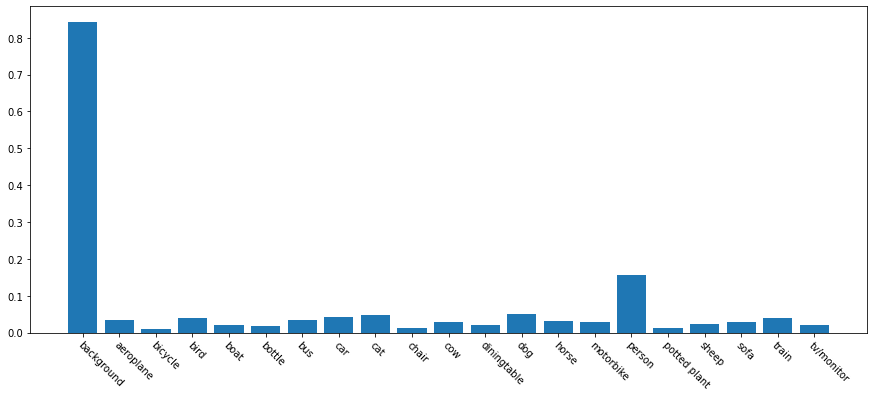

In [30]:
last_miou = val_miou.tolist()

fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xticks(range(num_labels))
ax.set_xticklabels(VOC_CLASSES)
plt.setp(ax.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
bars = plt.bar(range(num_labels), last_miou)
plt.bar_label(bars, labels=[("%.3lf" % elem) for elem in last_miou])
plt.show()

IndexError: ignored

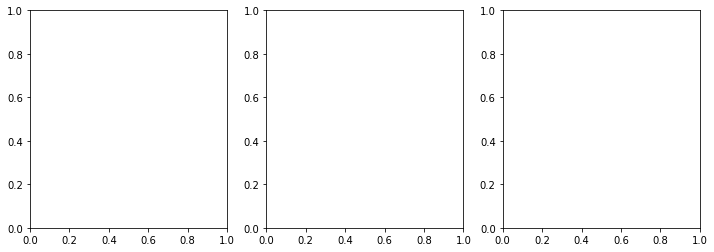

In [31]:
fig, axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predictions.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[0].imshow(simg.permute(1,2,0))
  axes[1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

#### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 





In [ ]:
from random import choices
from matplotlib.colors import ListedColormap

In [ ]:
def calculate_validation_ious():
    ious = []
    best_ious = [0.0 for _ in range(num_labels)]
    best_ious_indexes = [-1 for _ in range(num_labels)]

    model.eval()
    for img, lbl in tqdm(val_dataloader):
        with torch.no_grad():
            img = img.cuda()
            lbl = lbl.cuda()
            predictions = model(img)['out']
            cur_ious = IoU(predictions, lbl)
            batch_iou = cur_ious.mean(dim = 1)

            for i, cur_iou in enumerate(cur_ious):
                for i in range(num_labels):
                    if best_ious[i] < cur_iou[i].item():
                        best_ious[i] = cur_iou[i].item()
                        best_ious_indexes[i] = len(ious)+i

            ious += batch_iou.tolist()

    return ious, best_ious, best_ious_indexes

ious, best_ious, best_ious_indexes = calculate_validation_ious()

In [ ]:
def quantile_prediction(l, r = 1, k = 2, label = None):
    l_quantile = np.quantile(ious, l)
    l_mask = l_quantile < ious
    r_quantile = np.quantile(ious, r)
    r_mask = ious <= r_quantile

    mask = l_mask&r_mask

    # print(np.arange(len(ious))[mask])
    choosed_indexes = choices(np.arange(len(ious))[mask], k = k)

    fig, ax = plt.subplots(k, 3, sharey=True, figsize=(7,5))
    for i in range(k):
        img, lbl = validation_dataset[choosed_indexes[i]]
        prediction = model(img[None, ...].cuda())['out']
    
        ax[i, 0].imshow(img.permute(1,2,0))
        ax[i, 0].set_title('original image')
        ax[i, 1].imshow(prediction[0].argmax(0).cpu(), cmap=ListedColormap(VOC_COLORS / 255.0))
        ax[i, 1].set_title('prediction')
        ax[i, 2].imshow(lbl.argmax(0), cmap=ListedColormap(VOC_COLORS / 255.0))
        ax[i, 2].set_title('ground truth')

        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
    plt.suptitle(label)
    plt.show()

In [ ]:
quantile_prediction(0.9, label='Топ 10%')

In [ ]:
quantile_prediction(0.15, 0.25, label='Топ 15%-25%')

In [ ]:
quantile_prediction(0.45, 0.55, label='Топ 45%-55%')

In [ ]:
def best_prediction(classes, label = None):

    fig, ax = plt.subplots(len(classes), 3, figsize=(7,5))
    for i, cur_class in enumerate(classes):
        img, lbl = validation_dataset[best_ious_indexes[cur_class]]
        prediction = model(img[None, ...].cuda())['out']
    
        ax[i, 0].imshow(img.permute(1,2,0))
        ax[i, 1].imshow(prediction[0].argmax(0).cpu(), cmap=ListedColormap(VOC_COLORS / 255.0))
        ax[i, 2].imshow(lbl.argmax(0), cmap=ListedColormap(VOC_COLORS / 255.0))

        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].axis('off')
    plt.suptitle(label)
    plt.show()

In [ ]:
best_prediction(classes=[0, 1, 2], label='123')